# Homework 7: Decision Trees, Bagging, Random Forests
Part1 Decision Tree questions

Part2 Application to the real data

Part 3 Multiclass metrics

## Part 1 (3 pt) Basic elements of decision trees
**Write the code line that calculates the result.**

---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Q 1 (1 pt)** Given that 10 objects have reached a decision tree node, where 8 of them belong to class $C_1$, and 2 belong to class $C_2,$ calculate the impurity of this node, using entropy.

In [2]:
C_1 = 8
C_2 = 2

C_Total = C_1 + C_2
Entropy = -(np.log(C_1/C_Total)+np.log(C_2/C_Total))

Entropy

np.float64(1.83258146374831)

**Q2 (1 pt)** Additionally, it is known that the node from the previous task is not a leaf, and it is possible to split it in such a way that all objects of class $C_1$ end up in the left subtree and class $C_2$ objects end up in the right subtree. Calculate the (non-truncated) information gain criterion:

$$
Q = H(V) - \frac{|V_L|}{|V|}H(V_L) - \frac{|V_R|}{|V|}H(V_R).
$$
Now, $H(V)$ is calculated using Gini index:
$$
H(V) = \sum_{k=1}^C p_k(1-p_k),
$$
where $C$ is the number of classes (two in our case).

In [3]:
# Because the left and right branches contain only one class each, they have 0 entropy!
Q = ((C_1)*(C_Total-C_1)+(C_2)*(C_Total-C_2))/(C_Total**2)
Q

0.32

**Q3 (1 pt)** During the tree construction using MAE metric for impurity (a regression problem is being solved), a leaf node is formed with 10 objects, and the values of the target variable for these objects are as follows: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]. What will be the model's predictions for these objects?

In [4]:
# I'm just going to let Python sort this list to start off.
l = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
l.sort()
l, len(l)

([1, 5, 10, 18, 30, 47, 50, 61, 84, 100], 10)

In [5]:
mae = {}
for e in l :
  mae[e] = 0
  for elem in l :
    mae[e] += abs(elem - e)
mae

{1: 396,
 5: 364,
 10: 334,
 18: 302,
 30: 278,
 47: 278,
 50: 284,
 61: 328,
 84: 466,
 100: 594}

In [6]:
# Ok, so taking the split of x > 30 seems to give the least error.
# Let's take x > 30 as our split.

## Part 2: (12 pt) Bagging and Random Forest
We well work with the dataset from HW6. Just run all the cells below to cteate data for training and evaluation.

---

In [7]:
#m=pd.read_csv(path+'Members.csv',index_col='MemberID')
m=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Members.csv',index_col='MemberID')
#m.head()

In [8]:
#claims=pd.read_csv(path+'Claims_Y1.csv',index_col='MemberID')
claims=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Claims.csv',index_col='MemberID')
#claims.head()

In [9]:
#days2=pd.read_csv(path+'DaysInHospital_Y2.csv',index_col='MemberID')
days2=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/DaysInHospital_Y2.csv',index_col='MemberID')
#days2.head()

In [10]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

<ipython-input-10-a189b6f0acbb>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)


In [11]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

In [12]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)
#X.head()

In [13]:
X = X.join(m.Sex)
#X.head()

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [17]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['Sex'])], remainder='passthrough')

In [18]:
transform.fit(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist'),
                                 ['Sex'])])

In [19]:
X_train_transformed = pd.DataFrame(transform.transform(X_train),columns=transform.get_feature_names_out())
X_train_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,1.0,0.0,0.0,1.0,0.0,50.0
1,0.0,0.0,0.0,0.0,0.0,20.0
2,0.0,0.0,0.0,0.0,0.0,70.0
3,0.0,1.0,0.0,0.0,0.0,50.0
4,1.0,0.0,0.0,1.0,0.0,70.0


In [20]:
X_test_transformed = pd.DataFrame(transform.transform(X_test),columns=transform.get_feature_names_out())
X_test_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,0.0,0.0,0.0,0.0,3.0,30.0
1,0.0,0.0,1.0,1.0,1.0,80.0
2,1.0,0.0,0.0,0.0,0.0,40.0
3,0.0,0.0,0.0,0.0,0.0,60.0
4,0.0,0.0,0.0,1.0,0.0,80.0


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split

**Q4 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_leaf` for the `DecisionTreeClassifier`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the F1-score as the criterion (parameter `scoring` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the decision tree with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
possible_values = [{'max_depth':[1,2,3,4,5,6,7,8,9,10,20,30,40,50],
                    'min_samples_leaf':[2,3,4,5,10,15,20,25,50,100]}]

In [24]:
gscv = GridSearchCV(param_grid=possible_values, scoring='f1', estimator=DecisionTreeClassifier())

In [25]:
gscv.fit(X_train_transformed, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30,
                                        40, 50],
                          'min_samples_leaf': [2, 3, 4, 5, 10, 15, 20, 25, 50,
                                               100]}],
             scoring='f1')

In [26]:
gscv.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=20)

In [27]:
tree = DecisionTreeClassifier(max_depth=8, min_samples_leaf=20)
tree.fit(X_train_transformed, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=20)

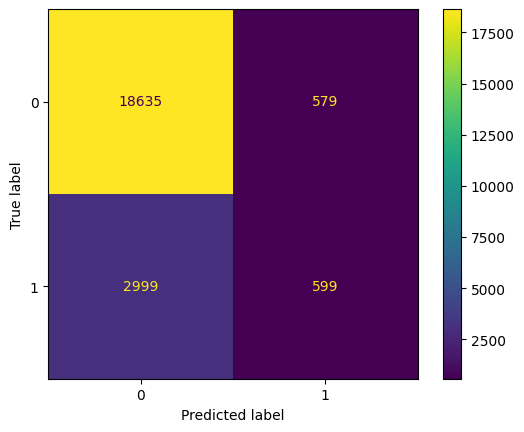

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, tree.predict(X_test_transformed))

In [29]:
recall_score(y_test, tree.predict(X_test_transformed))

0.16648137854363534

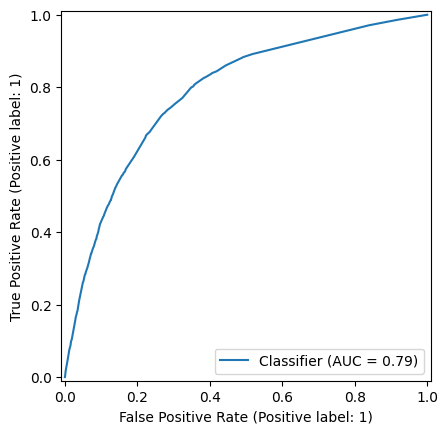

In [30]:
RocCurveDisplay.from_predictions(y_test, tree.predict_proba(X_test_transformed)[:,1])

**Q5 (3 pt)** Train [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with 50 trees on the training set, use parameter `max_samples=0.9`. Estimate the quality using metrics from the previous question.

In [31]:
bag = BaggingClassifier(max_samples=0.9, estimator=DecisionTreeClassifier(max_depth=8, min_samples_leaf=20))
bag.fit(X_train_transformed, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                   min_samples_leaf=20),
                  max_samples=0.9)

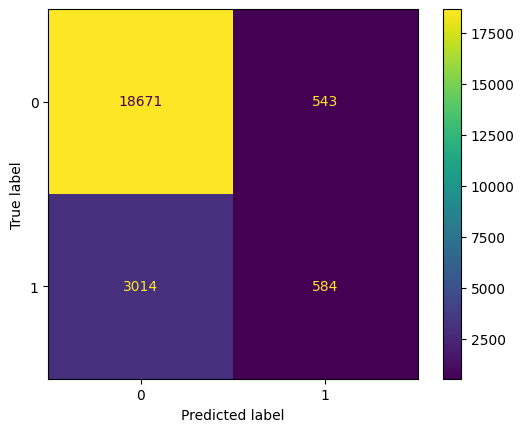

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test, bag.predict(X_test_transformed))

In [33]:
recall_score(y_test, bag.predict(X_test_transformed))

0.1623123957754308

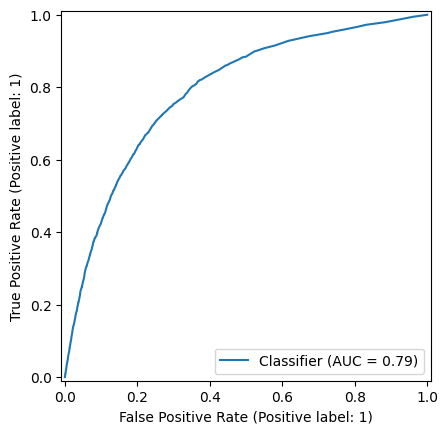

In [34]:
RocCurveDisplay.from_predictions(y_test, bag.predict_proba(X_test_transformed)[:,1])

In [35]:
# It appears that the bag is doing slightly worse in terms of recall.
# It just labels things with zeroes more, really.

**Q6 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_split` for the `Random Forest`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the f1-score as the criterion (parameter `scoring="f1"` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the random forest with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

Which of these models worked better?

In [36]:
clf_rf = RandomForestClassifier(class_weight='balanced')

In [37]:
clf_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [41]:
#possible_values = [{'max_depth':[1,2,3,4,5,6,7,8,9,10,20,30,40,50,None],
#                    'min_samples_leaf':[1,2,3,4,5,10,15,20,25,50,100,None],
#                    'n_estimators': [10,50,100,200],#,500,1000],
#                    'criterion': ['gini', 'entropy', 'log_loss'],
#                    }]#'max_features': ['sqrt', 'log2', None]}]

possible_values = [{'max_depth':[1,4,7,10,13,16], 'min_samples_leaf':[1,5,9,13,17,21,25], 'n_estimators':[100], 'criterion':['gini']}]

In [45]:
gscv2 = GridSearchCV(param_grid=possible_values, scoring='f1', estimator=clf_rf)

In [48]:
gscv2.fit(X_train_transformed, y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid=[{'criterion': ['gini'],
                          'max_depth': [1, 4, 7, 10, 13, 16],
                          'min_samples_leaf': [1, 5, 9, 13, 17, 21, 25],
                          'n_estimators': [100]}],
             scoring='f1')

In [49]:
forest = gscv2.best_estimator_
forest

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5)

In [51]:
possible_values = [{'max_depth':[7,8,9,10,11,12,13], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9], 'n_estimators':[100], 'criterion':['gini']}]
gscv3 = GridSearchCV(param_grid=possible_values, scoring='f1', estimator=clf_rf)
gscv3.fit(X_train_transformed, y_train)
forest = gscv3.best_estimator_
forest

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=6)

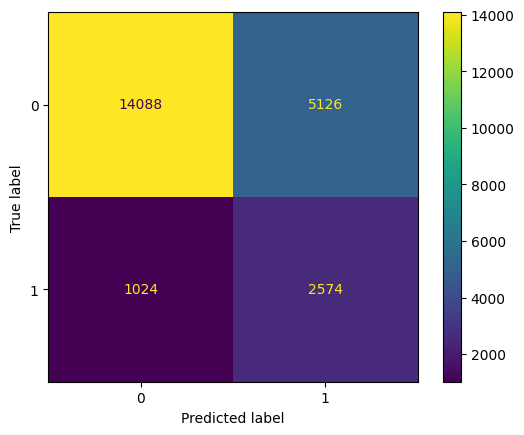

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test, forest.predict(X_test_transformed))

In [53]:
recall_score(y_test, forest.predict(X_test_transformed))

0.7153974430239022

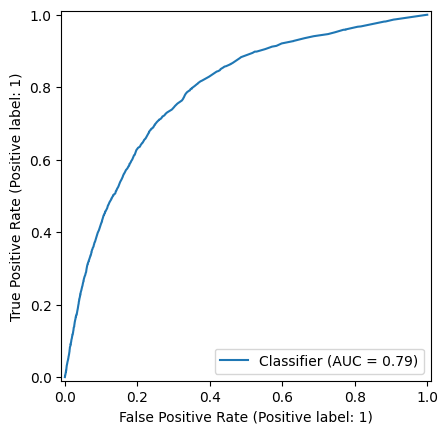

In [54]:
RocCurveDisplay.from_predictions(y_test, forest.predict_proba(X_test_transformed)[:,1])

In [55]:
# Ok, the random forest is just wildly better than the others. It takes a while to run, but boy is it worth it.

**Q7 (1 pt)** For the best model report the most relevant features, parameter `feature_importances_`

In [ ]:
forest.feature_importances_

## Part 3.
**Q8 (5 pt)** Given the confusion matrix, write the expression that calculates macro- and micro- f1-score. For macro-averaging we calculate f1 for every class and then average. For micro-averaging we average TP, FP, FN and then calculate metrics.

**Write the code that calculates f1-score using the numbers below**

In [56]:
np.random.seed(42)
y_target = np.random.randint(0, 3, 20)
y_pred = np.random.randint(0, 3, 20)

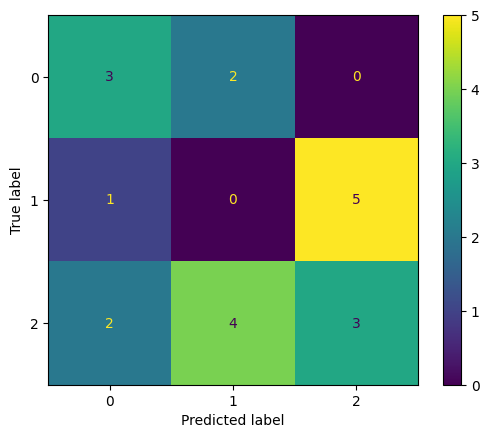

In [57]:
ConfusionMatrixDisplay.from_predictions(y_target, y_pred)

In [62]:
#your code and variables like Pr1, Rec1, etc - no buit-in functions
grid = [[np.sum((y_target == true_label) * (y_pred == predicted_label)) for predicted_label in range(3)] for true_label in range(3)]
grid

[[np.int64(3), np.int64(2), np.int64(0)],
 [np.int64(1), np.int64(0), np.int64(5)],
 [np.int64(2), np.int64(4), np.int64(3)]]

In [87]:
macro_f1_pieces = [(grid[0][0]/(grid[0][0]+grid[1][0]+grid[2][0]),grid[0][0]/(grid[0][0]+grid[0][1]+grid[0][2])),
                   (grid[1][1]/(grid[0][1]+grid[1][1]+grid[2][1]),grid[1][1]/(grid[1][0]+grid[1][1]+grid[1][2])),
                   (grid[2][2]/(grid[0][2]+grid[1][2]+grid[2][2]),grid[2][2]/(grid[2][0]+grid[2][1]+grid[2][2]))]
macro_f1_pieces = [2*piece[0]*piece[1]/(piece[0]+piece[1]) for piece in macro_f1_pieces]
macro_f1_pieces = [np.nan_to_num(piece) for piece in macro_f1_pieces]
micro_precision = 2*(grid[0][0]+grid[1][1]+grid[2][2])/20
micro_recall = 2*(grid[0][0]+grid[1][1]+grid[2][2])/20
micro_f1 = micro_precision * micro_recall / ( micro_precision + micro_recall )
macro_f1 = sum(macro_f1_pieces)/len(macro_f1_pieces)
macro_f1, micro_f1

<ipython-input-87-7bd3f25b3466>:4: RuntimeWarning: invalid value encountered in scalar divide
  macro_f1_pieces = [2*piece[0]*piece[1]/(piece[0]+piece[1]) for piece in macro_f1_pieces]


(np.float64(0.29946524064171126), np.float64(0.3))

In [81]:
f1_score(y_target, y_pred, average="macro"), f1_score(y_target, y_pred, average="micro")

(0.29946524064171126, 0.3)

In [82]:
f1_macro = macro_f1

In [83]:
from sklearn.metrics import make_scorer, f1_score

In [84]:
assert np.abs(f1_macro-f1_score(y_target, y_pred, average="macro")) < 1e-5

In [85]:
f1_micro = micro_f1

In [86]:
assert np.abs(f1_micro-f1_score(y_target, y_pred, average="micro")) < 1e-5